In [1]:
%load_ext autoreload
%autoreload 2
import sys 
import numpy as np

# RNN (Recurrent Neural Networks)
Articulos recomendado: 
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- http://blog.echen.me/2017/05/30/exploring-lstms/

## Que tienen de nuevo respecto a MLP y CNN?
- MLP y CNN solo aceptan un vector de entrada de tamaño fijo y devuelve un vector de salida de tamaño fijo
- RNN trabjan con secuencias tanto a la entrada como a la salida
- No tienen por que estrictamente tener una secuencia ni a la entrada ni a la salidad. De hecho hasta podrían no tener nada a la "entrada"

![rnn_types.jpeg](rnn_types.jpeg)

Aclaraciones: 
- Cada cuadrado NO es una neurona si no una capa que puede contener N neuronas
- Cada flecha representa la interconexión entre dos capas. Los pesos forman una matriz de la N1xN2 donde N1 y N2 son la cantidad de neuronas en cada capa respectivamente.

## Tipos
- **One to One**: CNN, MLP
- **One to many**: [Image captioning](https://www.youtube.com/watch?v=xKt21ucdBY0)
- **Many to one**: Sentiment Analisys, Detectar voz de hombre vs voz de mujer
- **Many to Many** [(sequence to sequence)](https://youtu.be/dkHdEAJnV_w): [Traducción](https://github.com/jganzabal/aind2-nlp-capstone/blob/master/machine_translation.ipynb) Dimensión de entrada differente a la de salida.
- **Many to Many Sincronizado**: Etiquetado de tramas de video, POS (Part of Speech) cada palabra se clasifica en verbo, articulo, etc, speech2text, text2speech, NER (Named Entity Recognition). Dimensión de entrada igual a dimensión de salida

# Modelos de lenguaje Generativos:
- Predecir la proxima palabra en funcion de las anteriores
- Predecir el proximo caracter en función de los anteriores

**Resultado**: Probabilidad dada la secuencia de caracteres o de palabras

**Aplicaciones de los modelos de lenguaje** (Mas allá de la posibilidad de generar texto):
- OCR
- Speach2Text
- Detección de autores

## "If training vanilla neural nets is optimization over functions, training recurrent nets is optimization over programs."
- Es una secuencia de ejecución mas que una clasificación
- Las RNN son Turing completo en principio [Turing Complete](https://en.wikipedia.org/wiki/Turing_completeness), [RNN Turing complete](http://binds.cs.umass.edu/papers/1995_Siegelmann_Science.pdf)

# Detalles de la arquitectura:

## Unidad de Elman o RNN unit

**Nota importante**: Cada unidad no es una neurona sino que una capa

![RNN%20vs%20FNN.png](RNN vs FNN.png)
¿Cual es el tamaño de $W_h$?

Todo se conecta con todo -> Si hay M hidden units tenemos $M^2$ $W_h$s 

## En ecuaciones:

### FFN

$h_t = f(W_x^T X_t + b_h)$

$y_t = softmax(W_o^T h_t + b_o)$

$f$ usualmente RELU, sigmoidea, etc

### RNN

$h_t = f(W_h^T h_{t-1} + W_x^T X_t + b_h)$

$y_t = softmax(W_o^T h_t + b_o)$

$f$ es tanh usualmente pero puede ser RELU, sigmoid, etc

In [2]:
# Ejemplo con dos neuronas en la capa oculta
M = 2 # Cantidad de neuronas en la capa oculta

h = np.array([1, -2]).reshape(2,1) # Valores iniciales de la capa oculta, vector columna de Mx1
Wh = np.array([[0,-1], [2,1]]) # Matriz de pesos de capa oculta MxM

# Dimension de entrada 3 en este ejemplo
Xt = np.array([1, -1, 2]).reshape(3,1) # vector columna
print('Xt')
print(Xt)
# Dimension de Wx?
Wx = np.array([[-1,1],[1,0],[2,1]]) # Dimensión 3x2 para que Wx.T sea de 2x3
print("Wx:")
print(Wx)

bh = np.array([-1, 1]).reshape(2,1) # Dimensión Mx1

print('h:')
print(h)
print('Wh:')
print(Wh)
print()
print('bh')
print(bh)
total_params_r_layer = Wh.shape[0]*Wh.shape[1] + Wx.shape[0]*Wx.shape[1] + bh.shape[0]
print('Cantidad de parametros de recurrente:', total_params_r_layer)

Xt
[[ 1]
 [-1]
 [ 2]]
Wx:
[[-1  1]
 [ 1  0]
 [ 2  1]]
h:
[[ 1]
 [-2]]
Wh:
[[ 0 -1]
 [ 2  1]]

bh
[[-1]
 [ 1]]
Cantidad de parametros de recurrente: 12


In [3]:
a = Wh.T.dot(h) + Wx.T.dot(Xt) + bh
h_ = np.tanh(a)
print(a)
print('h luego de time step:')
print(h_)

[[-3]
 [ 1]]
h luego de time step:
[[-0.99505475]
 [ 0.76159416]]


In [9]:
# Salida de 3 neuronas
Wo = np.array([[0.5, 0.4],[0.3, 0.5],[0.1, 0.5]]).reshape(2,3)
bo = np.array([0.5, 0.1, 0.2]).reshape(3,1)
ao = Wo.T.dot(h_) + bo
print('Wo')
print(Wo)
print('ao')
print(ao)
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
print('Salida')
print(softmax(ao))
total_params_out_layer = Wo.shape[0]*Wo.shape[1] + bo.shape[0]
print('Cantidad de parametros de capa densa de salida:', total_params_out_layer)

Wo
[[ 0.5  0.4  0.3]
 [ 0.5  0.1  0.5]]
ao
[[ 0.3832697 ]
 [-0.22186249]
 [ 0.28228065]]
Salida
[[ 0.4081724 ]
 [ 0.22286305]
 [ 0.36896455]]
Cantidad de parametros de capa densa de salida: 9


## Con keras

In [11]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential

Using TensorFlow backend.


In [12]:
rnn_neurons = 2
time_steps = 1000 # T
n_features = 3 # D
input_shape = (time_steps, n_features)
model = Sequential()
model.add(SimpleRNN(rnn_neurons, input_shape = input_shape))
model.add(Dense(3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 2)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


### Que es time_steps?

## Desplegando (Unfolding) la RNN
#### BPTT (Back-Propagation Through Time)
- Secuencia de longitud 5

![unfold%20RNN.png](unfold RNN.png)

Observaciones:
- Es como una FNN con 5 hidden layers pero con pesos compartidos (Shared weights): $W_h, W_o, W_x$
- Donde habiamos visto pesos compartidos?
- Se puede pensar como si h fuera la entrada y X es una señal de control en cada paso

Preguntas:
- Son todas las Y importantes? En que casos?
- Que diferencia hay entre estado interno (internal state) de la RNN y los pesos?
- Cada cuanto se resetea el estado interno? Y los pesos?

# Detalles de la entrada $X$

## Entrada en Vanilla Networks:

NxD, donde N es la cantidad de muestras y D es la cantidad de features

In [13]:
import numpy as np

In [14]:
# Ejemplo N = 3, D = 2
Ex_1 = np.array([[0.5, 0.3], [0.2, 0.1], [0.7, 0.3]])
print(Ex_1)
print(Ex_1.shape)

[[ 0.5  0.3]
 [ 0.2  0.1]
 [ 0.7  0.3]]
(3, 2)


## Entrada en RNNs:

Secuencias de longitud fija

NxTxD, donde T es la longitud de la secuencia

In [25]:
# Ejemplo N = 4, T = 3, D=2
Ex_2 = np.array([[[0.5, 0.3], [0.2, 0.1], [0.7, 0.3]], [[0.54, 0.1], [0.23, 0.3], [0.9, 0.1]], [[0.5, 0.3], [0.2, 0.1], [0.7, 0.3]], [[0.54, 0.1], [0.23, 0.3], [0.9, 0.1]]])
print(Ex_2)
print(Ex_2.shape)

[[[ 0.5   0.3 ]
  [ 0.2   0.1 ]
  [ 0.7   0.3 ]]

 [[ 0.54  0.1 ]
  [ 0.23  0.3 ]
  [ 0.9   0.1 ]]

 [[ 0.5   0.3 ]
  [ 0.2   0.1 ]
  [ 0.7   0.3 ]]

 [[ 0.54  0.1 ]
  [ 0.23  0.3 ]
  [ 0.9   0.1 ]]]
(4, 3, 2)


Secuencias de longitud variable

In [26]:
Ex_3 = np.array([[[0.5, 0.3], [0.7, 0.3]], [[0.54, 0.1], [0.23, 0.3], [0.9, 0.1]], [[0.7, 0.3]], [[0.54, 0.1], [0.23, 0.3], [0.9, 0.1]]])
print(Ex_3)
print(Ex_3.shape)
print(np.array(Ex_3[0]).shape)
print(np.array(Ex_3[1]).shape)
print(np.array(Ex_3[2]).shape)

[list([[0.5, 0.3], [0.7, 0.3]])
 list([[0.54, 0.1], [0.23, 0.3], [0.9, 0.1]]) list([[0.7, 0.3]])
 list([[0.54, 0.1], [0.23, 0.3], [0.9, 0.1]])]
(4,)
(2, 2)
(3, 2)
(1, 2)


En tensorflow es posible, en keras se suele hacer padding

¿Que pasa cuando tenemos longitudes distintas? Analizar el unfolding

### Desventajas de padding
- Podría haber una secuencia de longitud mayor en el test set. Que hacemos con eso?
- Es probable que los casos de secuencia largas sean poco probables por lo que realizaremos multiplicaciones de matrices innecesarias

## Ejemplos de preparación de datos para una RNN

### Predicción del valor de la acción de una empresa

Predecir el valor de las acciones de una compañia.
- Se utilizarán las 5 observaciones anteriores 
- Tenemos los datos de 138 días
- ¿Cuanto vale N, T, D?

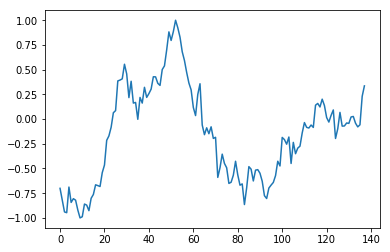

138


In [16]:
apple_stock = np.loadtxt('apple/normalized_apple_prices.csv')
from matplotlib import pyplot as plt
plt.plot(apple_stock)
plt.show()
print(len(apple_stock))

In [17]:
from RNN_utils import window_transform_series
X_, y = window_transform_series(apple_stock, 5)

In [18]:
print(X_.shape)
print(X_[0:10,:])

(133, 5)
[[-0.70062339 -0.82088484 -0.93938305 -0.9471652  -0.68785527]
 [-0.82088484 -0.93938305 -0.9471652  -0.68785527 -0.84325902]
 [-0.93938305 -0.9471652  -0.68785527 -0.84325902 -0.80532018]
 [-0.9471652  -0.68785527 -0.84325902 -0.80532018 -0.82058073]
 [-0.68785527 -0.84325902 -0.80532018 -0.82058073 -0.92023124]
 [-0.84325902 -0.80532018 -0.82058073 -0.92023124 -1.        ]
 [-0.80532018 -0.82058073 -0.92023124 -1.         -0.98814438]
 [-0.82058073 -0.92023124 -1.         -0.98814438 -0.85961411]
 [-0.92023124 -1.         -0.98814438 -0.85961411 -0.8706188 ]
 [-1.         -0.98814438 -0.85961411 -0.8706188  -0.92661512]]


In [21]:
# Parece un detalle pero las capas recurrentes en Keras exigen este formato
X = X_.reshape(X_.shape[0], X_.shape[1], 1) 

In [22]:
print('(N, T, D):')
print(X.shape)

(N, T, D):
(133, 5, 1)


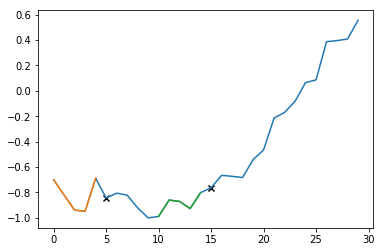

In [23]:
plt.plot(apple_stock[:30])
i1 = 0
plt.plot(range(i1,i1+5),X_[i1])
plt.scatter(i1+5, y[i1], marker='x', color='k')
i1 = 10
plt.plot(range(i1,i1+5),X_[i1])
plt.scatter(i1+5, y[i1], marker='x', color='k')

plt.show()

### Modelos de lenguaje
Predecir el siguiente caractar en función de los caracteres anteriores
- Utilizar one-hot encoding para los caracteres
- Tamaño de ventana de 100
- Cantidad total de caracteres de la obra: 67561
- Cantidad de caracteres diferentes: 71

In [24]:
text = open('federico-garcia-lorca/bodas_de_sangre.txt').read()
number_of_chars = len(text)
all_chars = sorted(set(text))
print('-----------------------------------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------------------------------')
print('Cantidad de caracteres: ' + str(number_of_chars))
print('Cantidad de caracteres unicos: ' + str(len(all_chars)))
print(all_chars)
print('-----------------------------------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------------------------------')
print()
print(text[:997])

-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------
Cantidad de caracteres: 67561
Cantidad de caracteres unicos: 71
['\n', ' ', '!', '(', ')', ',', '.', '1', '2', '3', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '¡', '¿', 'É', 'Ñ', 'á', 'é', 'í', 'ñ', 'ó', 'ú']
-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------

BODAS DE SANGRE(1933)

Poema trágico en tres actos y siete cuadros

Personajes
 
Madre
Criada
Leonardo
Mozos
Novia
Vecina
Novio
Leñadores
Suegra
Muchachas
Padre de la nov

In [25]:
from RNN_utils import window_transform_text, encode_io_pairs

window_size = 100
step_size = 1
inputs, outputs = window_transform_text(text,window_size,step_size)

In [26]:
print(inputs[0])
print()
print('-----------------------------------------------------------------------------------------------------')
print('Salida:',outputs[0])
print('-----------------------------------------------------------------------------------------------------')
print()
print(inputs[1])
print('-----------------------------------------------------------------------------------------------------')
print('Salida:',outputs[1])
print('-----------------------------------------------------------------------------------------------------')

BODAS DE SANGRE(1933)

Poema trágico en tres actos y siete cuadros

Personajes
 
Madre
Criada
Leonar

-----------------------------------------------------------------------------------------------------
Salida: d
-----------------------------------------------------------------------------------------------------

ODAS DE SANGRE(1933)

Poema trágico en tres actos y siete cuadros

Personajes
 
Madre
Criada
Leonard
-----------------------------------------------------------------------------------------------------
Salida: o
-----------------------------------------------------------------------------------------------------


## ¿Como ingresamos a la red con caracteres?
### Categorical Data (One-hot encoding)

In [27]:
X, y = encode_io_pairs(text, all_chars, window_size,step_size)

In [28]:
print('Caracteres codificado')
print(X[0,0:5].astype(int))

Caracteres codificado
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [29]:
print('(N,T,D):')
print(X.shape)

(N,T,D):
(67461, 100, 71)


## RNN en Keras
Definamos una capa RNN

In [43]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential

### SimpleRNN

In [31]:
rnn_neurons = 3
time_steps = 100# T
n_features = 71 # D
input_shape = (time_steps, n_features)
model = Sequential()
model.add(SimpleRNN(rnn_neurons, input_shape = input_shape))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 3)                 225       
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


Observaciones:
- Crece la cantidad de parametros con la cantidad de time_steps?
- Como puedo utilizar un MLP para que tenga en cuenta los time_steps? Que desventajas tengo?
- rnn_neurons = 1, n_features = 1, por que es 3? Cuales son en el diagrama?

In [46]:
def get_number_of_parameters(rnn_neurons, n_features):
    parametros = rnn_neurons*n_features + rnn_neurons**2 + rnn_neurons
    return parametros

In [47]:
get_number_of_parameters(3,3)

21

### SimpleRNN + Dense para predecir caracteres
Armar modelo con los siguientes datos:
N,T,D = (67461, 100, 71)

In [32]:
# (67461, 100, 71)
rnn_neurons = 200 # Hyperparametro para jugar
time_steps = 100 # T
n_features =  71# D
input_shape = (time_steps, n_features)
model = Sequential()
model.add(SimpleRNN(rnn_neurons, input_shape = input_shape))
model.add(Dense(n_features, input_shape = input_shape, activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 200)               54400     
_________________________________________________________________
dense_2 (Dense)              (None, 71)                14271     
Total params: 68,671
Trainable params: 68,671
Non-trainable params: 0
_________________________________________________________________


Observaciones:
- La cantidad de neuronas de la RNN queda para jugar (Overfitting, underfitting)

### SimpleRNN + Dense para stock prices

In [101]:
window_size = 40
rnn_cells = 10
model_rnn = Sequential()
model_rnn.add(SimpleRNN(rnn_cells, input_shape = (window_size,1)))
model_rnn.add(Dense(1))
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_19 (SimpleRNN)    (None, 10)                120       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


Observaciones:
- Capa densa. Que función de activación estamos usando?

## Un error común

In [102]:
model_rnn_error = Sequential()
model_rnn_error.add(SimpleRNN(rnn_cells, input_shape = (1,window_size)))
model_rnn_error.add(Dense(1))
model_rnn_error.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, 10)                510       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 11        
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


Preguntas:
- Que diferencia hay con la anterior?
- Por que la diferencia en cantidad de parámetros?
- Se puede pensar como un FNN (MLP)?

## FFN (MLP)

In [73]:
model_fnn = Sequential()
model_fnn.add(Dense(rnn_cells, input_shape=(window_size,) ))
model_fnn.add(Dense(1))
model_fnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 10)                410       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 11        
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


In [105]:
print('RNN')
print(model_rnn.layers[0].get_weights()[0].shape)
print(model_rnn.layers[0].get_weights()[1].shape)
print(model_rnn.layers[0].get_weights()[2].shape)
print()
print('RNN common error')
print(model_rnn_error.layers[0].get_weights()[0].shape)
print(model_rnn_error.layers[0].get_weights()[1].shape)
print(model_rnn_error.layers[0].get_weights()[2].shape)
print()
print('MLP')
print(model_fnn.layers[0].get_weights()[0].shape)
print(model_fnn.layers[0].get_weights()[1].shape)

RNN
(1, 10)
(10, 10)
(10,)

RNN common error
(40, 10)
(10, 10)
(10,)

MLP
(40, 10)
(10,)


## Stacking RNNs
### Podemos stackear varias capas?
![stack%20units.png](stack units.png)

In [ ]:
# No funciona por que la salida no tiene la dimensión correcta
# (67461, 100, 71)
rnn_neurons = 100 # Hyperparametro para jugar
time_steps = 100 # T
n_features =  71# D
input_shape = (time_steps, n_features)
model = Sequential()
model.add(SimpleRNN(rnn_neurons, input_shape = input_shape))
model.add(SimpleRNN(rnn_neurons))
model.add(Dense(n_features, input_shape = input_shape, activation="softmax"))
model.summary()

Por que falla?

In [ ]:
# (67461, 100, 71)
rnn_neurons_1 = 200 # Hyperparametro para jugar
rnn_neurons_2 = 150 # Hyperparametro para jugar
time_steps = 100 # T
n_features =  71# D
input_shape = (time_steps, n_features)
print(input_shape)
model = Sequential()
model.add(SimpleRNN(rnn_neurons_1, input_shape = input_shape, return_sequences=True))
model.add(SimpleRNN(rnn_neurons_2))
model.add(Dense(n_features, input_shape = input_shape, activation="softmax"))
model.summary()

# BPTT (Back-Propagation Through Time)
https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/

![BPTT.png](BPTT.png)

Con esto podemos calcular la "cross-entropy" y derivar respecto a $W_o$,$W_h$ y W_x para hallar el gradiente.

![BPTT_graph.png](BPTT_graph.png)

Problema: Vanishing/Exploding Gradient
Soluciones:
- Gradient Cliping
- Truncated BPTT (Limitar la cantidad de unfoldings)
- LSTM

# Resumiendo:
## RNN vs Vanilla Network
- Menor cantidad de parametros para resolver lo mismo
- En principio una FFN podria resolver con la misma precisión un problema resuelto por una RNN, pero es demasiado complejo encontrar la solución
- La estructura de la RNN simplifica la tarea de encontrar una solución de manera eficiente
- Ya sabemos que el problema tiene naturaleza recurrente (necesitamos memoria)
- FNN tienen que tener tamaño fijo en contraste con las RNNs

## Las RNN pueden resolver problemas muy diferentes desde el punto de vista del tipo de procesamiento sobre la secuencia
- Secuencia temporal modelada con "longitud infinita": Valor de acciones - Modelos tipo AR(N)
- Secuencias finitas "independientes" unas de otras: Sentiment analisys (Longitud variable), paridad (Longitud fija)
- Modelos de lenguaje: Por caracter o por palabra
- Seq2Seq: Traducción, chatbots, Image captioning

# LSTM (Long Short Term Memory) y GRU (Gated Recurrent Unit)

Si queremos que un modelo de lenguaje genere texto de este tipo:

Albert Einstein was a German-born theoretical physicist who developed the theory of relativity, one of the two pillars of modern physics (alongside quantum mechanics). **His** work is also known for its influence on the philosophy of science. **He** is best known by the general public for his mass–energy equivalence formula E = mc2 (which has been dubbed "the world's most famous equation"). **He** received the 1921 Nobel Prize in Physics "for **his** services to theoretical physics, and especially for his discovery of the law of the photoelectric effect", a pivotal step in the evolution of quantum theory.

Necesitamos memoria a largo plazo, que "recuerde" que se esta hablando de una persona de genero masculino y respete la gramática a lo largo del texto

![lstm.png](lstm.png)

- f -> forget Gate: "Porcentaje" que se queda de la LTM anterior
- i -> Remeber Gate: "Porcentaje" que pasa de lo actual
- o -> Learn Gate: "Porcentaje" a la salida o H (Recordar que h y la salida son lo mismo o STM)

## Ejemplo Cantidad de parametros

In [4]:
from keras.layers import LSTM
rnn_neurons = 1
time_steps = 100 # T
n_features = 1 # D
input_shape = (time_steps, n_features)
model = Sequential()
model.add(LSTM(rnn_neurons, input_shape = input_shape))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [5]:
def get_number_of_LSTM_params(rnn_neurons, n_features):
    return (rnn_neurons*n_features + rnn_neurons**2 + rnn_neurons)*4

In [7]:
get_number_of_LSTM_params(rnn_neurons, n_features)

12

### En las GRU $i_t$ y $f_t$ son complementarias $i_t + f_t=1$ por lo tanto las GRUs poseen menos parametros. Ademas, no se hace diferencia entre $c_t$ y $h_t$

### En las LSTM $c_t$ y $h_t$ son diferentes por lo que el estado de la celula es diferente a la salida. Esto es diferente tanto en la simpleRNN como en la GRU

## Ejemplo usando Model Api de Keras
https://keras.io/models/model/

In [110]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, TimeDistributed
features = 100
cells = 256
return_sequences=True

input_data = Input(shape=(None, features), name="inputs")
LSTM_cell = LSTM(cells, return_state=True, return_sequences=return_sequences, name="Encoder_LSTM")
LSTM_outputs, LSTM_state_h, LSTM_state_c = LSTM_cell(input_data)
print('LSTM')
print(LSTM_outputs) # LSTM_outputs y LSTM_state_h son diferentes solo si return_sequences=True
print(LSTM_state_h)
print(LSTM_state_c)
print()

GRU_cell = GRU(cells, return_state=True, return_sequences=return_sequences, name="Encoder_GRU")
GRU_outputs, GRU_state_h = GRU_cell(input_data)
print('GRU')
print(GRU_outputs)
print(GRU_state_h)

LSTM
Tensor("Encoder_LSTM_65/transpose_1:0", shape=(?, ?, 256), dtype=float32)
Tensor("Encoder_LSTM_65/while/Exit_2:0", shape=(?, 256), dtype=float32)
Tensor("Encoder_LSTM_65/while/Exit_3:0", shape=(?, 256), dtype=float32)

GRU
Tensor("Encoder_GRU_11/transpose_1:0", shape=(?, ?, 256), dtype=float32)
Tensor("Encoder_GRU_11/while/Exit_2:0", shape=(?, 256), dtype=float32)


In [80]:
# Esto es solo un ejemplo de como definir el modelo Model Api en Keras
# La cantidad de neuronas de la GRU tiene que ser igual a la cantidad de features 
# con lo que sale de la LSTM. Tambien return_sequences tiene que ser True
print(LSTM_outputs)
stacked_output, _ = GRU_cell(LSTM_outputs)
model = Model(inputs=input_data, outputs=stacked_output)
model.summary()

Tensor("Encoder_LSTM_58/transpose_1:0", shape=(?, ?, 256), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, None, 256)         0         
_________________________________________________________________
Encoder_LSTM (LSTM)          [(None, None, 256), (None 525312    
_________________________________________________________________
Encoder_GRU (GRU)            [(None, None, 256), (None 393984    
Total params: 919,296
Trainable params: 919,296
Non-trainable params: 0
_________________________________________________________________


# Bidirectional RNNs

In [107]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Bidirectional
features = 256
cells = 256
return_sequences=True

input_data = Input(shape=(None, features))
LSTM_cell = LSTM(cells, return_state=True, return_sequences=return_sequences)
Bi_LSTM_cell = Bidirectional(LSTM_cell)
print(Bi_LSTM_cell)
LSTM_cell(input_data)
#LSTM_outputs, LSTM_state_h2, LSTM_state_h1, LSTM_state_c1, LSTM_state_c2 = Bi_LSTM_cell(input_data)
#print('LSTM')
#print(LSTM_outputs) # LSTM_outputs y LSTM_state_h son diferentes solo si return_sequences=True
#print(LSTM_state_h)
#print(LSTM_state_c)
#print()

[<tf.Tensor 'lstm_4/transpose_1:0' shape=(?, ?, 256) dtype=float32>,
 <tf.Tensor 'lstm_4/while/Exit_2:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'lstm_4/while/Exit_3:0' shape=(?, 256) dtype=float32>]

### Aplicaciones
- Traducción
- **No es buena** para predecir el futuro en secuencias temporales
- Clasificación de imagenes

![BiLSTM-Image-classif.png](biLSTM-image-class-complete.png)

[](BiLSTM-Image-classif)